In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt


# 1) Загрузка
tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

target = tr.pop('target')
order_id = tst.pop('order_id')

tr['time_to_order_seconds'] = (tr['session_end_time'] - tr['order_create_time']).dt.total_seconds()
tst['time_to_order_seconds'] = (tst['session_end_time'] - tst['order_create_time']).dt.total_seconds()

# удаляем исходные метки времени
tr = tr.drop(columns=['order_create_time', 'session_end_time'])
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

threshold_hard = -2000
tr['hard_call'] = (tr['time_to_order_seconds'] < threshold_hard).astype(int)
tst['hard_call'] = (tst['time_to_order_seconds'] < threshold_hard).astype(int)

In [2]:
tr

,model_1,model_2,model_3,model_4,model_5,time_to_order_seconds,hard_call
0,0.798127,0.644805,0.039843,1,0.430339,-544.607,0
1,-0.573826,0.220081,0.020889,0,0.177593,1926.407,0
2,-0.665887,0.644805,0.039810,0,0.431897,-75.483,0
3,-0.284625,0.644805,0.040026,0,0.432045,831.153,0
4,-1.710108,-0.221541,0.020585,0,0.174115,-232.743,0
...,...,...,...,...,...,...,...
104590,-0.784541,0.220081,0.020901,0,0.188639,2674.990,0
104591,-0.504846,0.220081,0.029831,0,0.175063,-41689.227,1
104592,-1.710108,-0.221541,0.021167,0,0.191408,51.047,0
104593,-0.403279,0.644805,0.040814,0,0.452594,-304.027,0


In [3]:
import plotly.express as px
from sklearn.manifold import TSNE

# Выбираем только временные признаки
features = ['time_to_order_seconds', 'hard_call']
X = tr[features].fillna(-999999999)

# Сэмплируем X и target синхронно
sampled = X.sample(10000, random_state=42)
sampled_target = target.loc[sampled.index]

# Применяем t-SNE для понижения размерности
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(sampled)

# Создаем DataFrame для визуализации
tsne_df = pd.DataFrame({
    'tsne_1': X_tsne[:, 0],
    'tsne_2': X_tsne[:, 1],
    'target': sampled_target.values,
    'time_to_order_seconds': sampled['time_to_order_seconds'].values,
    'hard_call': sampled['hard_call'].values
})

# Создаем колонку с уникальными комбинациями target и hard_call
tsne_df['target_hardcall'] = tsne_df['target'].astype(str) + '_' + tsne_df['hard_call'].astype(str)

# Визуализация через Plotly
fig = px.scatter(
    tsne_df,
    x='tsne_1',
    y='tsne_2',
    color='target_hardcall',  # раскрашиваем по комбинации
    title='t-SNE по временным признакам: target + hard_call',
    hover_data=['time_to_order_seconds', 'hard_call', 'target']
)

fig.show()


In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE

# 1) Подготовка full как у тебя
features = ['time_to_order_seconds', 'hard_call']

tr2 = tr.copy()
tr2['is_test'] = 0

tr2['target'] = target

tr2['label'] = tr2['target'].astype(str) + '_' + tr2['hard_call'].astype(str)

tst2 = tst.copy()
tst2['is_test'] = 1
tst2['label'] = 'test'

full = pd.concat([
    tr2[features + ['is_test','label']],
    tst2[features + ['is_test','label']]
], axis=0)

# 2) Делим на группы по label и делаем подвыборку
np.random.seed(42)
samples = []
for lbl, size in [('0_0', 50), ('0_1', 50), ('1_0', 50), ('1_1', 50)]:
    grp = full[full['label']==lbl]
    samples.append(grp.sample(min(size, len(grp)), random_state=42))
# для теста
grp_test = full[full['label']=='test']
samples.append(grp_test.sample(min(100, len(grp_test)), random_state=42))

sub = pd.concat(samples, axis=0)

# 3) Запускаем t‑SNE на подвыборке
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
coords = tsne.fit_transform(sub[features].fillna(-999999999))

sub = sub.assign(
    tsne_1 = coords[:,0],
    tsne_2 = coords[:,1],
)

# 4) Визуализируем
fig = px.scatter(
    sub,
    x='tsne_1',
    y='tsne_2',
    color='label',
    symbol='is_test',
    hover_data=features + ['is_test']
)
fig.update_layout(title='t-SNE на подвыборке train+test')
fig.show()


In [5]:
from sklearn.neighbors import KNeighborsClassifier

# допустим, у вас уже есть sub — подвыборка train+test с колонками:
#   features, 'is_test', 'label', 'tsne_1', 'tsne_2'

# 1) Разбиваем sub обратно на train и test
sub_train = sub[sub['is_test'] == 0].copy()
sub_test  = sub[sub['is_test'] == 1].copy()

# 2) Обучаем KNN на подвыборке train
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(
    sub_train[features].fillna(-999999999).values,
    sub_train['label'].values
)

# 3) Предсказываем для подвыборки test
sub_test['neighbor_label'] = knn.predict(
    sub_test[features].fillna(-999999999).values
)

# 4) Объединяем обратно
sub_with_neighbors = pd.concat([sub_train, sub_test], axis=0)

# 5) Визуализируем с учетом neighbor_label
import plotly.express as px

fig = px.scatter(
    sub_with_neighbors,
    x='tsne_1', y='tsne_2',
    color='neighbor_label',    # теперь раскраска по KNN-метке
    symbol='is_test',
    hover_data=features + ['label', 'neighbor_label']
)
fig.update_layout(title='t-SNE на подвыборке + цвета от ближайших соседей')
fig.show()


In [6]:
sub_test

,time_to_order_seconds,hard_call,is_test,label,tsne_1,tsne_2,neighbor_label
11123,-506670.290,1,1,test,-30.401173,0.643442,0_1
10381,74.833,0,1,test,17.661575,0.013313,0_0
3053,-504.443,0,1,test,2.898500,-0.685862,1_0
6504,-8097.153,1,1,test,-11.450387,0.035836,0_1
3501,386.537,0,1,test,23.760765,0.968556,0_0
...,...,...,...,...,...,...,...
2250,529.720,0,1,test,25.074139,1.195281,0_0
15824,-315.893,0,1,test,6.289160,-0.844091,1_0
9796,214.177,0,1,test,21.343493,0.657261,1_0
1261,1987.743,0,1,test,29.914682,1.569742,0_0


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt


# 1) Загрузка
tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

target = tr.pop('target')
order_id = tst.pop('order_id')

tr['time_to_order_seconds'] = (tr['session_end_time'] - tr['order_create_time']).dt.total_seconds()
tst['time_to_order_seconds'] = (tst['session_end_time'] - tst['order_create_time']).dt.total_seconds()

# удаляем исходные метки времени
tr = tr.drop(columns=['order_create_time', 'session_end_time'])
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

threshold_hard = -400
tr['hard_call'] = (tr['time_to_order_seconds'] < threshold_hard).astype(int)
tst['hard_call'] = (tst['time_to_order_seconds'] < threshold_hard).astype(int)

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1) Подготовка исходного датасета
# tr — ваш исходный train без временных колонок, с целевой «target» и «hard_call»
# создаём колонку label = "target_hardcall"
tr2 = tr.copy()

tr2['target'] = target

tr2['label'] = tr2['target'].astype(str) + '_' + tr2['hard_call'].astype(str)

features = ['time_to_order_seconds', 'hard_call']

# 2) Делим на train/val
train_df, val_df = train_test_split(
    tr2,
    test_size=0.2,
    stratify=tr2['label'],
    random_state=42
)


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[features].fillna(-999999999))
X_val = scaler.transform(val_df[features].fillna(-999999999))

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(
    train_df[features].fillna(-999999999).values,
    train_df['label'].values
)

# 4) Предсказываем на валидации
val_pred_label = knn.predict(val_df[features].fillna(-999999999).values)


# 5) Оцениваем
print("=== Отчёт по предсказанным меткам label ===")
print(classification_report(val_df['label'], val_pred_label))

# 6) Разбираем компонентно и считаем точность по target и по hard_call
# истинные компоненты
true_target   = val_df['label'].str.split('_').str[0].astype(int).values
true_hardcall = val_df['label'].str.split('_').str[1].astype(int).values

# предсказанные компоненты
pred_target   = pd.Series(val_pred_label).str.split('_').str[0].astype(int).values
pred_hardcall = pd.Series(val_pred_label).str.split('_').str[1].astype(int).values

print(f"Accuracy по target:     {accuracy_score(true_target,   pred_target):.4f}")
print(f"Accuracy по hard_call:  {accuracy_score(true_hardcall, pred_hardcall):.4f}")


=== Отчёт по предсказанным меткам label ===
              precision    recall  f1-score   support

         0_0       0.79      0.93      0.86      9760
         0_1       0.64      0.75      0.69      3739
         1_0       0.60      0.29      0.39      3379
         1_1       0.72      0.62      0.67      4041

    accuracy                           0.73     20919
   macro avg       0.69      0.65      0.65     20919
weighted avg       0.72      0.73      0.71     20919

Accuracy по target:     0.7346
Accuracy по hard_call:  1.0000


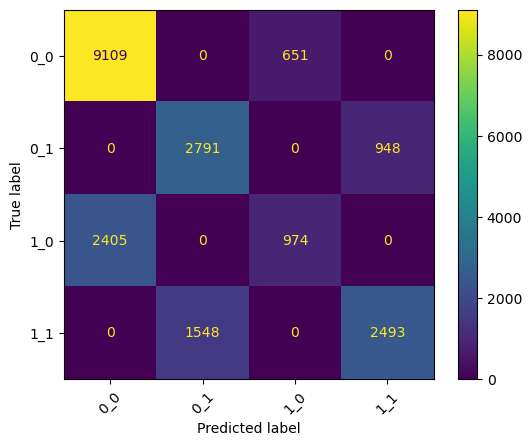

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(val_df['label'], val_pred_label, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(xticks_rotation=45)
plt.show()


In [ ]:
ы

In [ ]:
train_df

,model_1,model_2,model_3,model_4,model_5,time_to_order_seconds,hard_call,target,cluster,label
57139,0.798127,0.644805,0.040868,1,0.459061,-1080.337,0,1,0,1_0
55444,-0.441443,0.644805,0.045736,0,0.454157,-13938.827,1,1,1,1_1
49323,-0.573826,0.220081,0.020997,0,0.190521,1042.720,0,0,0,0_0
40697,-0.573826,0.644805,0.040078,0,0.439701,1807.547,0,1,0,1_0
36220,-1.208107,0.220081,0.020200,0,0.162741,208.977,0,0,0,0_0
...,...,...,...,...,...,...,...,...,...,...
45549,0.884988,0.644805,0.041027,1,0.473779,-306.523,0,1,0,1_0
76037,-0.573826,0.220081,0.020735,0,0.174115,133.400,0,0,0,0_0
59381,0.746851,0.644805,0.041918,1,0.504076,-288.650,0,1,0,1_0
46784,-0.573826,0.220081,0.020626,0,0.170298,3536.763,0,0,0,0_0


In [ ]:
import pandas as pd
import numpy as np

def create_time_features(df, order_time_col='order_create_time', session_end_col='session_end_time'):
    """
    Создает новые временные признаки на основе колонок с временными метками.
    
    Параметры:
    df - DataFrame с данными
    order_time_col - название колонки с временем создания заказа (timestamp)
    session_end_col - название колонки с временем окончания сессии (timestamp)
    
    Возвращает:
    DataFrame с добавленными новыми признаками
    """
    # Создаем копию DataFrame чтобы избежать предупреждений
    df = df.copy()
    
    # Преобразуем колонки в datetime, если они еще не в этом формате
    df[order_time_col] = pd.to_datetime(df[order_time_col])
    df[session_end_col] = pd.to_datetime(df[session_end_col])
    
    # 1. Разница между окончанием сессии и созданием заказа (в секундах)
    df['time_to_order_seconds'] = (df[session_end_col] - df[order_time_col]).dt.total_seconds()
    
    # 2. Признаки времени создания заказа
    df['order_hour'] = df[order_time_col].dt.hour
    df['order_day_of_week'] = df[order_time_col].dt.dayofweek  # 0-понедельник, 6-воскресенье
    df['order_day_of_month'] = df[order_time_col].dt.day
    df['order_month'] = df[order_time_col].dt.month
    df['order_week_of_year'] = df[order_time_col].dt.isocalendar().week
    df['order_is_weekend'] = df[order_time_col].dt.dayofweek >= 5
    
    # 3. Признаки времени окончания сессии
    df['session_end_hour'] = df[session_end_col].dt.hour
    df['session_end_day_of_week'] = df[session_end_col].dt.dayofweek
    df['session_end_day_of_month'] = df[session_end_col].dt.day
    df['session_end_month'] = df[session_end_col].dt.month
    df['session_end_week_of_year'] = df[session_end_col].dt.isocalendar().week
    df['session_end_is_weekend'] = df[session_end_col].dt.dayofweek >= 5
    
    # 4. Разница во времени в разных единицах
    df['time_to_order_minutes'] = df['time_to_order_seconds'] / 60
    df['time_to_order_hours'] = df['time_to_order_seconds'] / 3600
    
    # 5. Временные категории (утро/день/вечер/ночь)
    bins = [-1, 6, 12, 18, 23]
    labels = ['night', 'morning', 'afternoon', 'evening']
    df['order_time_of_day'] = pd.cut(df['order_hour'], bins=bins, labels=labels)
    df['session_end_time_of_day'] = pd.cut(df['session_end_hour'], bins=bins, labels=labels)
    
    # 6. Является ли заказ сделан в тот же день, что и сессия
    df['same_day_order'] = df[order_time_col].dt.date == df[session_end_col].dt.date
    
    # 7. Сезонность (времена года)
    def get_season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'autumn'
    
    df['order_season'] = df['order_month'].apply(get_season)
    df['session_end_season'] = df['session_end_month'].apply(get_season)
    
    return df

In [33]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# === 0) ваши признаки и подготовка ===
time_feats = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'time_to_order_seconds', 'hard_call']

# === 1) Разбиваем на train/valid (мы используем весь tr, без подвыборки) ===
X_train, X_valid, y_train, y_valid = train_test_split(
    tr,
    target,
    test_size=0.2,
    random_state=42,
    stratify=target
)

# === 2) Добавляем KNN‑фичу knn_pred_target ===
# 2.1) строим комбинированную метку для KNN
train_knn = X_train.copy()

train_knn['target'] = target

train_knn['label'] = (
    train_knn['target'].astype(str) + '_' +
    train_knn['hard_call'].astype(int).astype(str)
)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(
    train_knn[time_feats].fillna(-999999999).values,
    train_knn['label'].values
)

# 2.2) предсказываем для TRAIN — чтобы LightGBM видел «правильную» фичу на обучении
X_train = X_train.copy()
X_train['knn_pred_target'] = train_knn['target'].astype(int)

# 2.3) предсказываем для VALID
X_valid = X_valid.copy()
knn_labels_valid = knn.predict(
    X_valid[time_feats].fillna(-999999999).values
)
# извлекаем из строки «0_1» только первую цифру — предсказание target
X_valid['knn_pred_target'] = (
    pd.Series(knn_labels_valid)
      .str.split('_').str[0]
      .astype(int)
      .values
)

# === 3) Готовим LightGBM-датасеты ===
all_feats = time_feats + ['knn_pred_target']

train_data = lgb.Dataset(
    X_train[all_feats], label=y_train,
)
valid_data = lgb.Dataset(
    X_valid[all_feats], label=y_valid,
    reference=train_data,
)

# === 4) Параметры и обучение ===
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_child_samples': 20,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train','valid'],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50)
    ]
)

# === 5) Оценка на валидации ===
val_pred = model.predict(X_valid[all_feats])
val_auc = roc_auc_score(y_valid, val_pred)
print(f'Validation AUC: {val_auc:.4f}')

# === 6) Предсказание на тесте ===
# Для test сначала строим knn_pred_target тем же KNN:
tst = tst.copy()
knn_labels_test = knn.predict(
    tst[time_feats].fillna(-999999999).values
)
tst['knn_pred_target'] = (
    pd.Series(knn_labels_test)
      .str.split('_').str[0]
      .astype(int)
      .values
)

test_pred = model.predict(tst[all_feats])

# === 7) Сохраняем сабмишн ===
submission = pd.DataFrame({
    'order_id': order_id,
    'target': test_pred
})
submission.to_csv('submission.csv', index=False)


Training until validation scores don't improve for 50 rounds
[50]	train's auc: 1	valid's auc: 0.942319
[100]	train's auc: 1	valid's auc: 0.942703
[150]	train's auc: 1	valid's auc: 0.94319
[200]	train's auc: 1	valid's auc: 0.943178
[250]	train's auc: 1	valid's auc: 0.943455
[300]	train's auc: 1	valid's auc: 0.943474
Early stopping, best iteration is:
[291]	train's auc: 1	valid's auc: 0.943505
Validation AUC: 0.9435
